# Quantum Sudoku Solver
This is a jupyter notebook on solving a sudoku while leveraging the power of quantum computing. If it wasn't obvious enough, this has no practical use and is instead meant as a demonstration of quantum computing applications.

In [1]:
from typing import List, Tuple

import cv2
import heapq
import os, sys
import numpy as np
import pytesseract
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_algorithms.minimum_eigensolvers import QAOA, MinimumEigensolver

## Setup
We'll be representing the Sudoku grid where each cell is 1 qubit with 9 possible results with binary encoding. We'll have several parts to this.
### Sudoku image parsing
In this section we'll take an image of some Sudoku board and parse it into a text format that will be sent to the next section.

    Errors encountered:
        Image parsing failed with .heic files or poorly exported .jpg files
        Pytesseract parsing failed to recognise edges on warped images causing it to ignore the number right in front of it
            Fix was to crop out the dark edge lines of the cells
            Fix did not work. It shall be a quirk of the program
            I might just incorporate my neural network and train on a sudoku 
        Pytesseract sucks and won't get the correct number, so I'm going to find something better, my own CNN might work!
            No it did not work, mostly because there's no good dataset to train the model on especially when there's empty squares, let alone the variety of fonts used :(

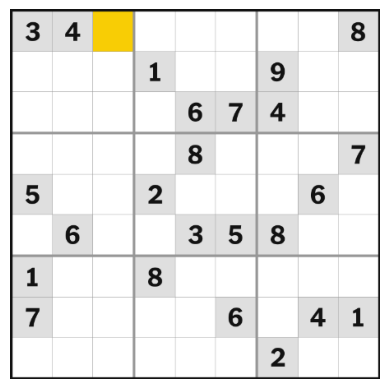

In [2]:
# Import image file
file = "SudokuBoard.jpg"
image = cv2.imread(file)

# Convert to greyscale
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply gaussian blur
blurred_image = cv2.GaussianBlur(grey_image, (5, 5), 0)

# Find the edges of the board
edges = cv2.Canny(blurred_image, 100, 200)

# Find the contours of the board
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area
contours = sorted(contours, key=cv2.contourArea, reverse=True) # Reverse for largest size first

# Draw the largest contour (hopefully the grid)
sudoku_contour = contours[0]

# Approximate to a 4-sided polygon for awkward images
epsilon = 0.04 * cv2.arcLength(sudoku_contour, True)
approx = cv2.approxPolyDP(sudoku_contour, epsilon, True)



# Resize image to board edges: #

# Perspective transform matrix
pts1 = np.float32([approx[0], approx[1], approx[2], approx[3]])
# Define the output size
width, height = 450, 450
pts2 = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# Apply perspective transformaiton
matrix = cv2.getPerspectiveTransform(pts1, pts2)
warped_image = cv2.warpPerspective(image, matrix, (width, height))
warped_image = cv2.flip(warped_image, 1)
warped_image = cv2.rotate(warped_image, cv2.ROTATE_90_COUNTERCLOCKWISE)


# Show the cropped Sudoku board
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.axis('off')
plt.show()

In [3]:
# Seperate into an array of images for every cell
cell_size = 450 // 9
cells = []

for i in range(9):
    for j in range(9):
        x1 = j * cell_size
        y1 = i * cell_size
        x2 = (j + 1) * cell_size
        y2 = (i + 1) * cell_size

        cell = warped_image[y1:y2, x1:x2]

        cells.append(cell)

# Find text elements and convert
numbers = []
for i, cell in enumerate(cells):
    grey_cell = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    _, thresh_cell = cv2.threshold(grey_cell, 150, 255, cv2.THRESH_BINARY_INV)

    num = pytesseract.image_to_string(thresh_cell, config='--psm 10 --oem 3')
    number = ''.join(filter(str.isdigit, num))

    if number:
        numbers.append(int(number))
    else:
        numbers.append('.')
        
sudoku_board_not_enc = np.array(numbers).reshape(9, 9)
board_str = ''.join(str(x) for x in numbers)

In [4]:
print(sudoku_board_not_enc)

[['.' '4' '.' '.' '.' '.' '.' '.' '8']
 ['.' '.' '.' '1' '.' '.' '9' '.' '.']
 ['.' '.' '.' '.' '6' '7' '4' '.' '.']
 ['.' '.' '.' '.' '8' '.' '.' '.' '7']
 ['5' '.' '.' '2' '.' '.' '.' '6' '.']
 ['.' '6' '.' '.' '3' '5' '8' '.' '.']
 ['.' '.' '.' '8' '.' '.' '.' '.' '.']
 ['7' '.' '.' '.' '.' '6' '.' '4' '1']
 ['.' '.' '.' '.' '.' '.' '2' '.' '.']]


In [5]:
# Fix any misplacements or incorrect numbers
sudoku_board_not_enc[0][0] = '3'
numbers[0] = 3
sudoku_board_not_enc[6][0] = '1'
numbers[6 * 9] = 1

# Check new board
print(sudoku_board_not_enc)

[['3' '4' '.' '.' '.' '.' '.' '.' '8']
 ['.' '.' '.' '1' '.' '.' '9' '.' '.']
 ['.' '.' '.' '.' '6' '7' '4' '.' '.']
 ['.' '.' '.' '.' '8' '.' '.' '.' '7']
 ['5' '.' '.' '2' '.' '.' '.' '6' '.']
 ['.' '6' '.' '.' '3' '5' '8' '.' '.']
 ['1' '.' '.' '8' '.' '.' '.' '.' '.']
 ['7' '.' '.' '.' '.' '6' '.' '4' '1']
 ['.' '.' '.' '.' '.' '.' '2' '.' '.']]


## Problem setup
We'll set up our problem to solve the sudoku using QAOA via QUBO formulation. This method will seek the lowest-energy solution that satisfies all Sudoku constraints.

## Define Variables
We'll encode our cells that are filled with 4-bit binaries.

In [6]:
# Assign binary values for defined numbers
for i in range(len(numbers)):
    number = numbers[i]
    if isinstance(number, int):
        numbers[i] = bin(number)[2:].zfill(4)
    else:
        continue

# Resize board to array shape
sudoku_board = np.array(numbers).reshape(9, 9)

In [7]:
# We'll add a bit here to define an array to make sure we know why qubits will be predefined
predefined = []
for i in range(len(numbers)):
    if numbers[i] != '.':
        for j in range(4):
            predefined.append(1)
    else:
        for j in range(4):
            predefined.append(0)

## Encode states into the qubits
Writing a function here to convert binary value to quantumcircuit.

In [8]:
# Create the circuit for the cell
def create_cell_circuit(value: str) -> QuantumCircuit:
    """
    Returns a sub-circuit with just the number provided, this is to create an easy to understand grouping of qc's in the quantum register
    inp: str(int)
    out: QuantumCircuit(4)
    """
    qc = QuantumCircuit(4)
    superpos_states = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ampl = [1 / (9**0.5) if i in superpos_states else 0 for i in range(16)]

    if value != '.':
        for i, bit in enumerate(value):
            if bit == '1':
                qc.x(i)
    # Here is the tricky part, we want an equal superposition only from 0001 to 1001, because those are the only numbers allowed
    elif value == '.':
        qc.initialize(ampl, [0, 1, 2, 3])

    return qc

Now we'll output the function into a quantum register.

In [9]:
# Initial quantum circuits list
qcs = []
for cell in numbers:
    qc = create_cell_circuit(cell)
    qcs.append(qc)

# Appending to our quantum register
qc = QuantumCircuit(324) # 324 from (4 * 81)

offset = 0
for qci in qcs:
    qc.compose(qci, qubits=range(offset, offset + 4), clbits=None, inplace=True)
    offset += 4

# Uncomment to check the circuit!
#qc.draw('mpl')

## Define constraints
To define the constraints we'll construct pair comparisons of cells:
\begin{equation}
H_{\text{row, col, 3x3 grid}} = \sum_{i < j} (\text{Penalty} \cdot (\text{State of 4-qubit pairs(i, j)})).
\end{equation}
We'll allow this penalty to be to be applied on matching 4-qubits pairs for each qubit individually. The difficulty here is figuring out how to compare qubits using quantum gates. However, luckily the solution is fairly simple! We can use a combination of CNOT, and Z gates to check similar variables. Here is an example circuit:
<center>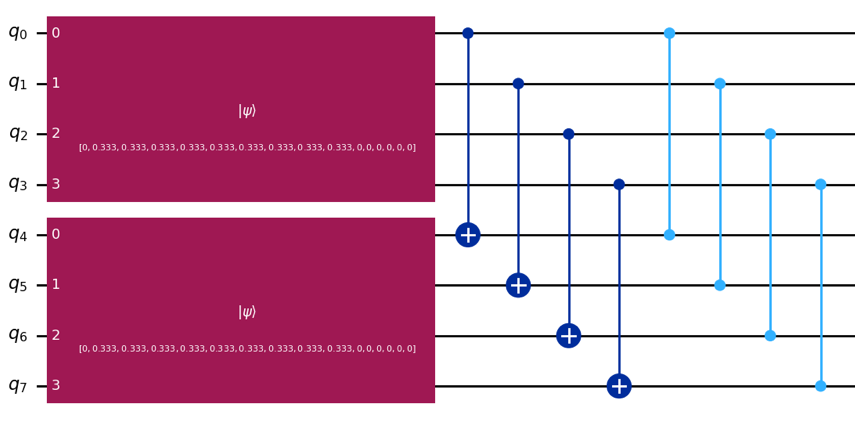</center>

We want a pure comparison hamiltonian, then we need to iterate for each row, column, and subgrid.
\begin{equation}
H_{\text{row, col, 3x3 grid}} = (q_1 - q_2)^2,
\end{equation}
where this is 0 if q1 != q2 and 1 if q1 = q2. This will be achieved with, $$q_1 \oplus q_2.$$ Resulting in our desired comparison penalty of,
\begin{equation}
H_{\text{penalty}} = \text{Z}(q_2) \cdot \text{CNOT}(q1, q2),
\end{equation}
the squared logic is implicit in the modulo binary operation, the Z gate applies the penalty for matching qubits.

#### This has since been redefined a few times
The ising hamiltonian will encode the difference with the Pauli-Z operators. The original correct unitary circuit is commented out, I could not convert this to match the format required by the QAOA later on, so I've left it here if any improvements are made in the future.

In [10]:
# Comparison penalty
def penalty(qc: QuantumCircuit, qubit_pairs: List[Tuple[int, int]], gamma: float, predefined: list[int]) -> SparsePauliOp: # example qubit_pairs = [(0, 4), (1, 5), (2, 6), (3, 7)]
    """
    This function takes a quantum circuit and it's two sets 4-qubits to apply a penalty. It will perform this if, q1 and q2 are not defined,
    or if q1 is defined and q2 is not defined.
    
    inp: qc: QuantumCircuit - our quantum circuit
         A quantum circuit, and a list of qubit pairs we wish to operate on
    out: None: None - Nothing, our circuit is affected already
         A circuit affected by the penalty
    """
    # We need an array to check for predefined values, so we'll go back to our encoding function to define another array to store this
    num_qubits = 324
    pauli_strings = []

    # Add penalty terms for each qubit pair
    for qubit1, qubit2 in qubit_pairs:
        # Check predefined conditions
        #if predefined[qubit1] == 1 and predefined[qubit2] == 0:
            # Apply gates to qubit2 only, as qubit1 is predefined
         #   qc.cx(qubit1, qubit2)
         #   qc.rz(2 * gamma, qubit2)
         #   qc.cz(qubit1, qubit2)
        
        # If both are not predefined, apply penalty gates
        #elif predefined[qubit1] == 0 and predefined[qubit2] == 0:
           # qc.cx(qubit1, qubit2)
           # qc.rz(2 * gamma, qubit2)
           # qc.cz(qubit1, qubit2)

        # If qubit1 is predefined and qubit2 is undefined, don't apply gates to qubit1
        if predefined[qubit1] == 1 and predefined[qubit2] == 1:
            continue  # No operations if both are predefined

        # Construct diagonal Pauli term for the Hamiltonian
        pauli_str = ['I'] * num_qubits
        if predefined[qubit1] == 0:
            pauli_str[qubit1] = 'Z'  # Apply penalty to qubit1 if not predefined
        if predefined[qubit2] == 0:
            pauli_str[qubit2] = 'Z'  # Apply penalty to qubit2 if not predefined
        
        hamiltonian_terms.append(gamma * SparsePauliOp(''.join(pauli_str)))
    
    # Sum up all penalty terms to form the Hamiltonian
    full_hamiltonian = sum(hamiltonian_terms)
    
    return full_hamiltonian

### Uniqueness pairs
We'll define a global variable to store all pair constraints

In [11]:
pairs = []

### Row Uniqueness
We want to apply our penalty for every combination of qubits in every row.

In [12]:
# Use sudoku_board to find indexes and give qubit pairs
#To check rows, we create pairs of qubits along the row, we'll find the row in sudoku_board
for i in range(len(sudoku_board)):
    for j in range(len(sudoku_board)):
        qsingle = (i * 9 * 4) + (j * 4)
        for k in range(len(sudoku_board)):
            if k != j:
                single = (i * 9 * 4) + (k * 4)
                for x in range(4):
                    pairs.append((qsingle + x, single + x))

### Column Uniqueness
We want to apply our penalty for every combination of qubits in every column

In [13]:
for j in range(len(sudoku_board)):
    for i in range(len(sudoku_board)):
        qsingle = (i * 9 * 4) + (j * 4)
        for k in range(len(sudoku_board)):
            if k != i:
                single = (k * 9 * 4) + (j * 4)
                for x in range(4):
                    pairs.append((qsingle + x, single + x))

### Subgrid Uniqueness
We finally need the pairs penalty for every combination of qubits in every subgrid

In [14]:
for subgrid_row in range(0, len(sudoku_board), 3):  # Step by 3 to go over each subgrid row
    for subgrid_col in range(0, len(sudoku_board), 3):  # Step by 3 to go over each subgrid column
        # Iterate over elements within the 3x3 subgrid
        for i in range(subgrid_row, subgrid_row + 3):
            for j in range(subgrid_col, subgrid_col + 3):
                qsingle = (i * 9 * 4) + (j * 4)
                for k in range(subgrid_row, subgrid_row + 3):
                    for l in range(subgrid_col, subgrid_col + 3):
                        if (i != k or j != l):  # Ensure not pairing the same element
                            single = (k * 9 * 4) + (l * 4)
                            for x in range(4):
                                pairs.append((qsingle + x, single + x))

## Quantum Solution / QAOA Circuit Setup

With our pairs now prepared, we can apply our constraints to a SparsePauliOp, which we'll optimise with QAOA.

In [15]:
def quantum_solver(qc, pairs, predefined):
    # Define gamma parameter
    gamma = 1.5
    
    # Generate our hamiltonian
    penalty_ham = penalty(qc, pairs, gamma, predefined)
    
    # Define backend - imported AerSimulator
    backend = AerSimulator()
    
    # Define the optimiser
    optimiser = COBYLA(maxiter=100) # If COBYLA isn't working use: SPSA(maxiter=200)
    
    # Setup QAOA
    qaoa = QAOA(optimizer=optimiser, sampler=backend, reps=1)
    
    # Run QAOA
    result = qaoa.compute_minimum_eigenvalue(penalty_ham)
    
    # Return result
    print("Optimal parameters:", result.optimal_parameters)
    print("Optimal value:", result.eigenvalue)
    
    # Get the probabilities of each basis state
    probabilities = result.eigenstate.probabilities()
    
    # Get the index of the most probable basis state
    most_probable_index = np.argmax(probabilities)
    
    # Number of qubits - Really should be a global variable
    num_qubits = 324
    
    # Convert the index to a bitstring
    bitstring = bin(most_probable_index)[2:].zfill(num_qubits)
    
    # Convert to 4-bit groups
    bit_groups = [bitstring[i:i+4] for i in range(0, len(bitstring), 4)]
    
    # Convert the 4-bit groups to integers
    ints = [int(froup, 2) for group in bit_groups]

## Backup solution
If you're stuck in a world where we're limited by the number of qubits, then why not just apply the sudoku solver on a classical computer instead!

In [16]:
def classical_solver(board: List[List[str]]) -> List[List[str]]:
    print(board)
    rows = [set() for _ in range(9)] # numbers used in row
    cols = [set() for _ in range(9)] # numbers used in col
    grids = [[set() for _ in range(3)] for _ in range(3)] # numbers used in grid
    empty_cells = []
    for i, row in enumerate(board): # collect numbers and add empty cells
        for j, value in enumerate(row):
            if value == ".": # found empty cell
                empty_cells.append((i, j))
            else: # found number
                rows[i].add(value)
                cols[j].add(value)
                grids[i//3][j//3].add(value)                     

    # [ (potential numbers for cell), i, j] 
    empty_cells = [
        (9 - len(rows[i] | cols[j] | grids[i//3][j//3]), i, j)
        for i, j in empty_cells
    ]
    heapq.heapify(empty_cells) # sort by lowest potential numbers for cell

    def fill_board():
        if not empty_cells: 
            return True # finished filling board

        _, i, j = heapq.heappop(empty_cells)
        row = rows[i]
        col = cols[j]
        grid = grids[i//3][j//3]
        potential_nums = 0  
        for value in '123456789': # check possible numbers for each cell
            if (value in row or value in col or value in grid): 
                continue # skip if number present in row, col, or grid

            board[i][j] = value # add number to board and row / col / grid
            row.add(value)
            col.add(value)
            grid.add(value)

            if fill_board(): # try to fill in rest of board
                return True

            row.remove(value) # couldn't fill rest of board, take out used number
            col.remove(value)
            grid.remove(value)
            potential_nums += 1 # didn't use value, add another option for cell

        heapq.heappush(empty_cells, (potential_nums, i, j)) # didn't fill cell, add back to empty cells
        return False
        
    fill_board()
    return board

## Conclusion
We will finally parse the result backwards through our text and image parser to return an image result of our Sudoku board.

In [17]:
# Run either the classical or quantum algorithm
board = classical_solver(sudoku_board_not_enc).flatten().tolist()
#board = quantum_solver(qc, pairs, predefined)

# Remove predefined values for a better final image
for i, val in enumerate(board):
    if predefined[i * 4] == 1: # times by 4 because predefined is encoded in 4-bit binaries, stupid solution to this issue
        board[i] = " "

[['3' '4' '.' '.' '.' '.' '.' '.' '8']
 ['.' '.' '.' '1' '.' '.' '9' '.' '.']
 ['.' '.' '.' '.' '6' '7' '4' '.' '.']
 ['.' '.' '.' '.' '8' '.' '.' '.' '7']
 ['5' '.' '.' '2' '.' '.' '.' '6' '.']
 ['.' '6' '.' '.' '3' '5' '8' '.' '.']
 ['1' '.' '.' '8' '.' '.' '.' '.' '.']
 ['7' '.' '.' '.' '.' '6' '.' '4' '1']
 ['.' '.' '.' '.' '.' '.' '2' '.' '.']]


In [18]:
# Image is stored in warped_image with dimensions 450 x 450
cell_size = 450 // 9
spacing = -1

# Grid dimensions
rows = 9
cols = 9

# Calculate the positions of the cells
cell_positions = []
for i in range(rows):
    for j in range(cols):
        x = j * (cell_size + spacing)
        y = i * (cell_size + spacing)
        cell_positions.append((x, y))

In [19]:
for (x, y), number in zip(cell_positions, board):
    # Define the text and positions
    text_x = x + cell_size // 4 + 5
    text_y = y + cell_size // 1 - 10

    # Draw the text
    cv2.putText(warped_image, number, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

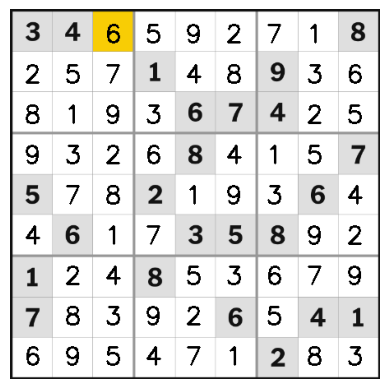

In [20]:
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.axis('off')
plt.show()